In [27]:
import os
from pathlib import Path


os.chdir(Path.cwd().parent)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from src.optimizers.step_controllers.step_controllers import (
    StepControllerBase, ConstantController, BacktrackingLineSearchController
)
from src.optimizers.riemannian_newton_method import RiemannianNewtonIterations
from src.optimizers.utils.report import basic_report
from src.rayleigh_quotient import rayleigh_quotient
from src.utils.linalg import (
    generate_normalized_vector, generate_supersymmetric_tensor, tenvec
)


In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def test_riemannian_newton_method_base(
    A: np.ndarray,
    x: np.ndarray,
    step_controllers: list[StepControllerBase] = [ConstantController(), BacktrackingLineSearchController()],
    *,
    plot: bool = False,
    show_label: bool = False,
    verbose: bool = False) -> None:
    """
    Ensures Riemannian Newthon method for f(x) = R_A(X) converges to eigenpair.

    :param A: supersymmetric tensor of shape (n x n x ... x n) of order k
    :param x: normalized vector of shape (n,)
    :paran step_controllers: step controllers to use.
        Default is to use all implemented with default parameters
    :param plot: whether to plot f_history and f_grad_norm_history
    :param show_label: whether to show label(name) of step controller when plotting
    :param verbose: whether to print more info
    """
    if verbose:
        print(f"testing Riemannian Newton method with parameters:\n"
              f"tensor A of shape {A.shape}\nA = {A}\n"
              f"vector x = {x}")
    k = A.ndim
    method = RiemannianNewtonIterations.from_tensor(A, invalid="fix")

    if plot:
        fig, axs = plt.subplots(3, 2, figsize=(12, 12))
        fig.suptitle(f"Riemannian-Newthon method statistics for tensor of shape {A.shape}", fontsize=18)

        axs[0, 0].set(title="Rayleigh quotient values log scaled")
        axs[0, 1].set(title="Rayleigh quotient residual values log scaled")
        axs[1, 0].set(title="Rayleigh quotient gradient norm values log scaled")
        axs[1, 1].set(title="Rayleigh quotient gradient residual norm values log scaled")
        axs[2, 0].set(title="Linear solver deviation log scaled")
        axs[2, 1].set(title="Step sign on each iteration")

    success_all = True
    for step_controller in step_controllers:
        name = step_controller.name()
        X_eign = method.minimize(x, step_controller=step_controller)
        rq_eign = rayleigh_quotient(A, X_eign)

        X_expected = rq_eign * X_eign
        X_computed = tenvec(A, X_eign, times=k-1)

        success = np.allclose(X_expected, X_computed, atol=1e-4)
        if success:
            if plot:
                f_hist, f_residual_hist, f_grad_norm_hist, f_grad_residual_norm_hist = basic_report(method._f, method._f_grad, method._x_history)
                yscales = np.array([
                    ['linear', 'log'], ['log', 'log'], ['log', 'linear']
                ])
                for i, stat in enumerate([
                    f_hist, f_residual_hist, f_grad_norm_hist,
                    f_grad_residual_norm_hist, method.lin_solver_error_history, np.sign(method._step_history)
                    ]):
                    idx = np.unravel_index(i, (3, 2))
                    axs[idx].plot(range(len(stat)), stat, label=name)
                    axs[idx].set_yscale(yscales[idx])
                    axs[idx].grid(True)
                    if show_label:
                        axs[idx].legend()

                fig.tight_layout()

        else:
            print(f"Riemannian-Newton method with {name} step controller failed", file=sys.stderr)
            success_all = False
    assert success_all


In [31]:
def test_riemannian_newton_method_simple() -> None:
    n = 2
    k = 2
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_riemannian_newton_method_base(a, x, plot=True, show_label=True)

def test_riemannian_newton_method_simple_demo() -> None:
    n = 2
    k = 2
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_riemannian_newton_method_base(a, x, [ConstantController()], plot=True, show_label=False)

def test_riemannian_newton_method_medium() -> None:
    n = 3
    k = 3
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_riemannian_newton_method_base(a, x, plot=True, show_label=True)

def test_riemannian_newton_method_hard() -> None:
    n = 6
    k = 6
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_riemannian_newton_method_base(a, x, plot=True, show_label=True)

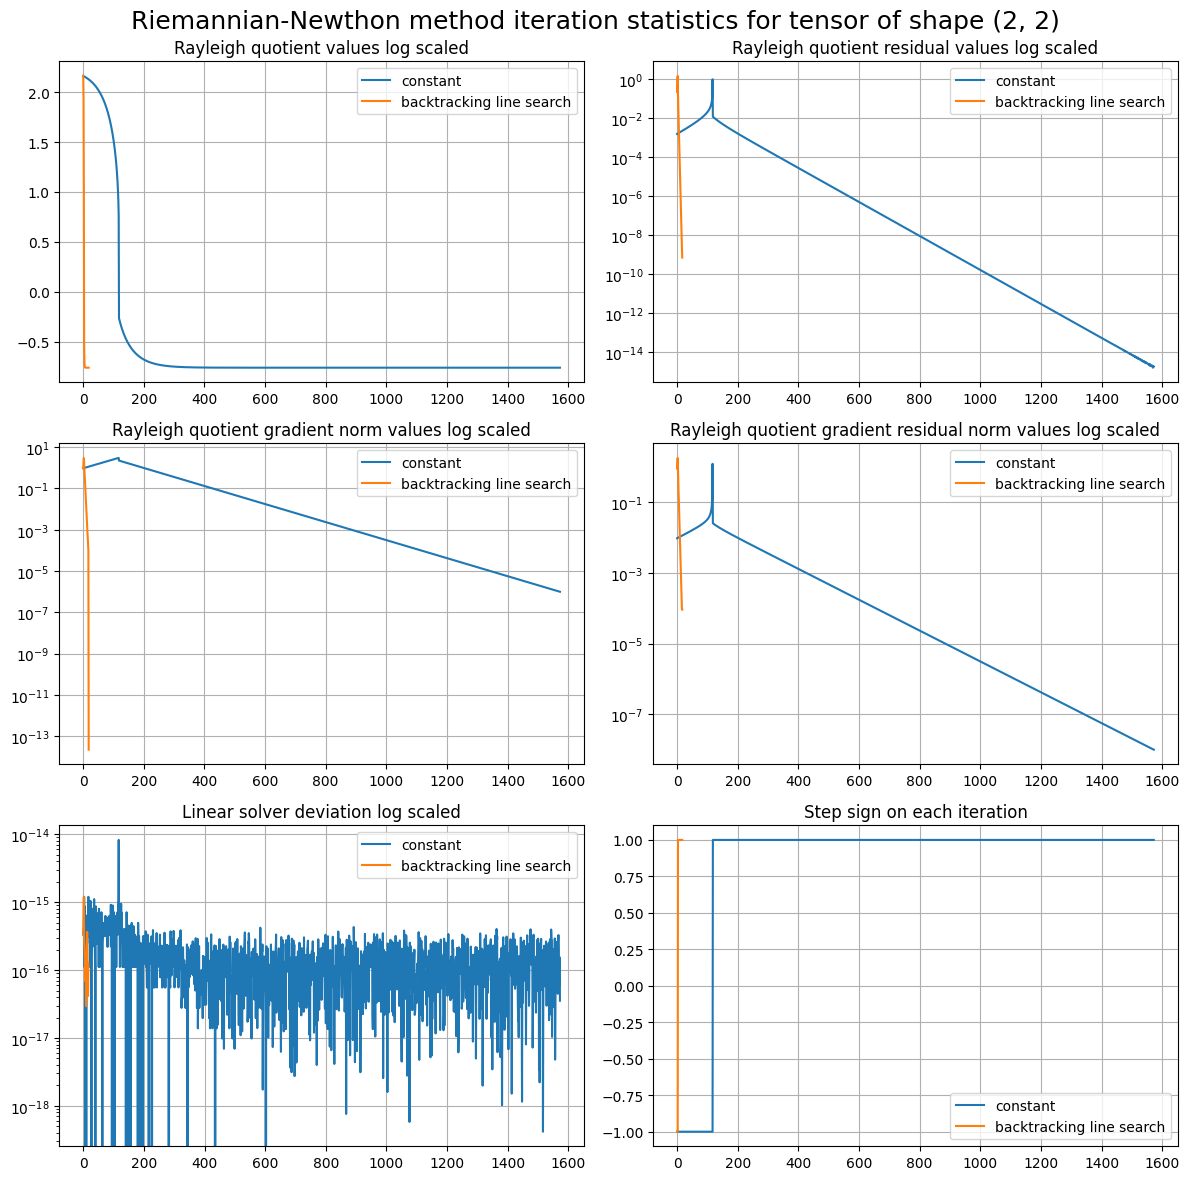

In [32]:
test_riemannian_newton_method_simple()

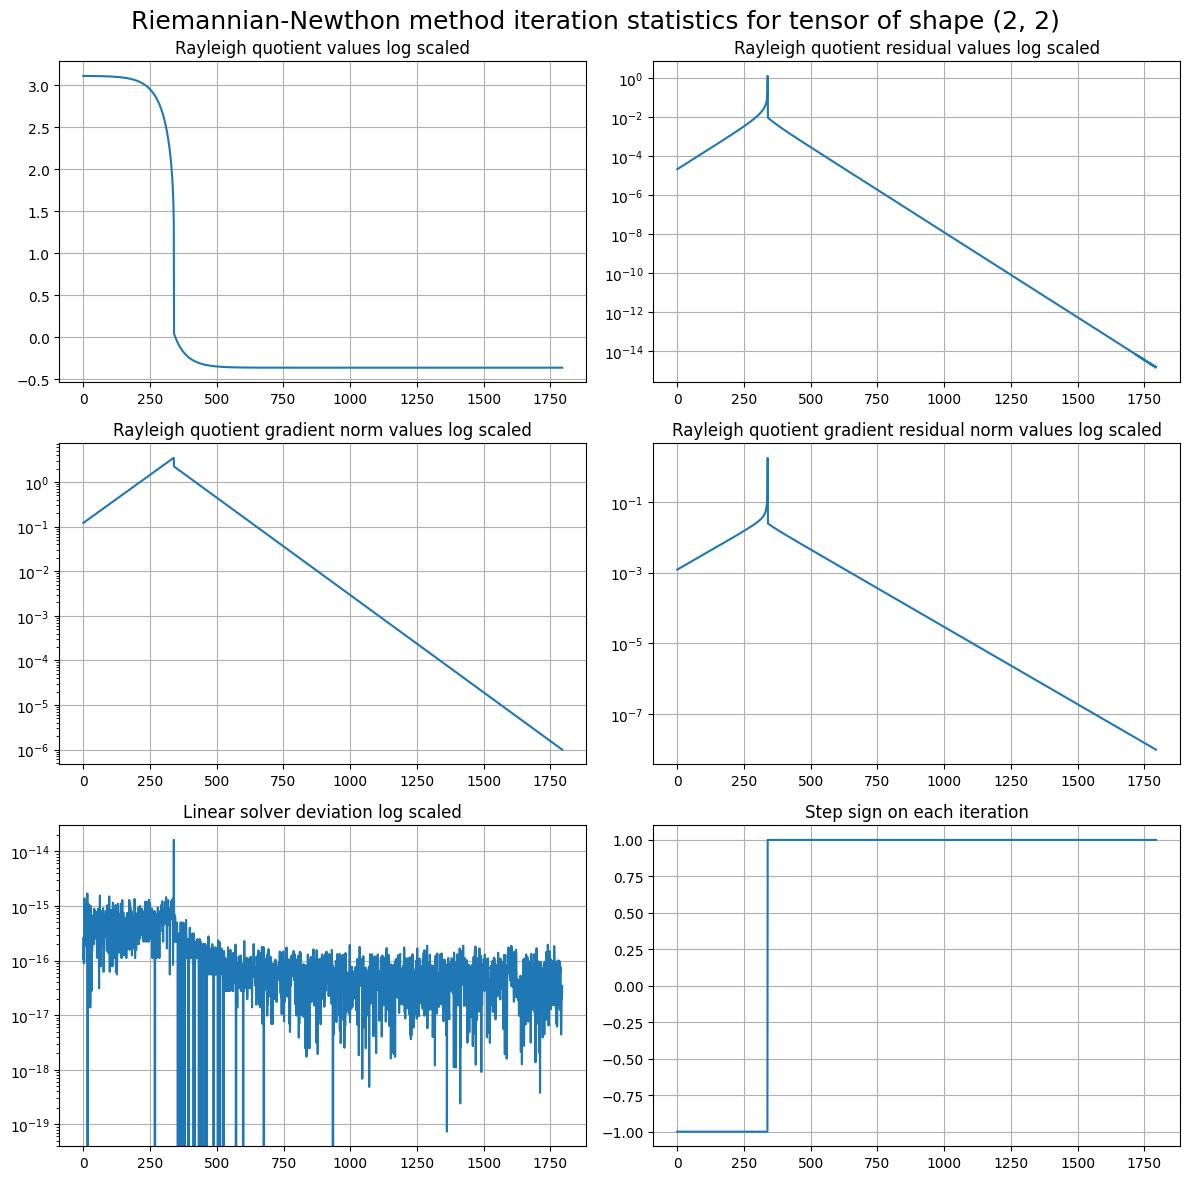

In [33]:
test_riemannian_newton_method_simple_demo()

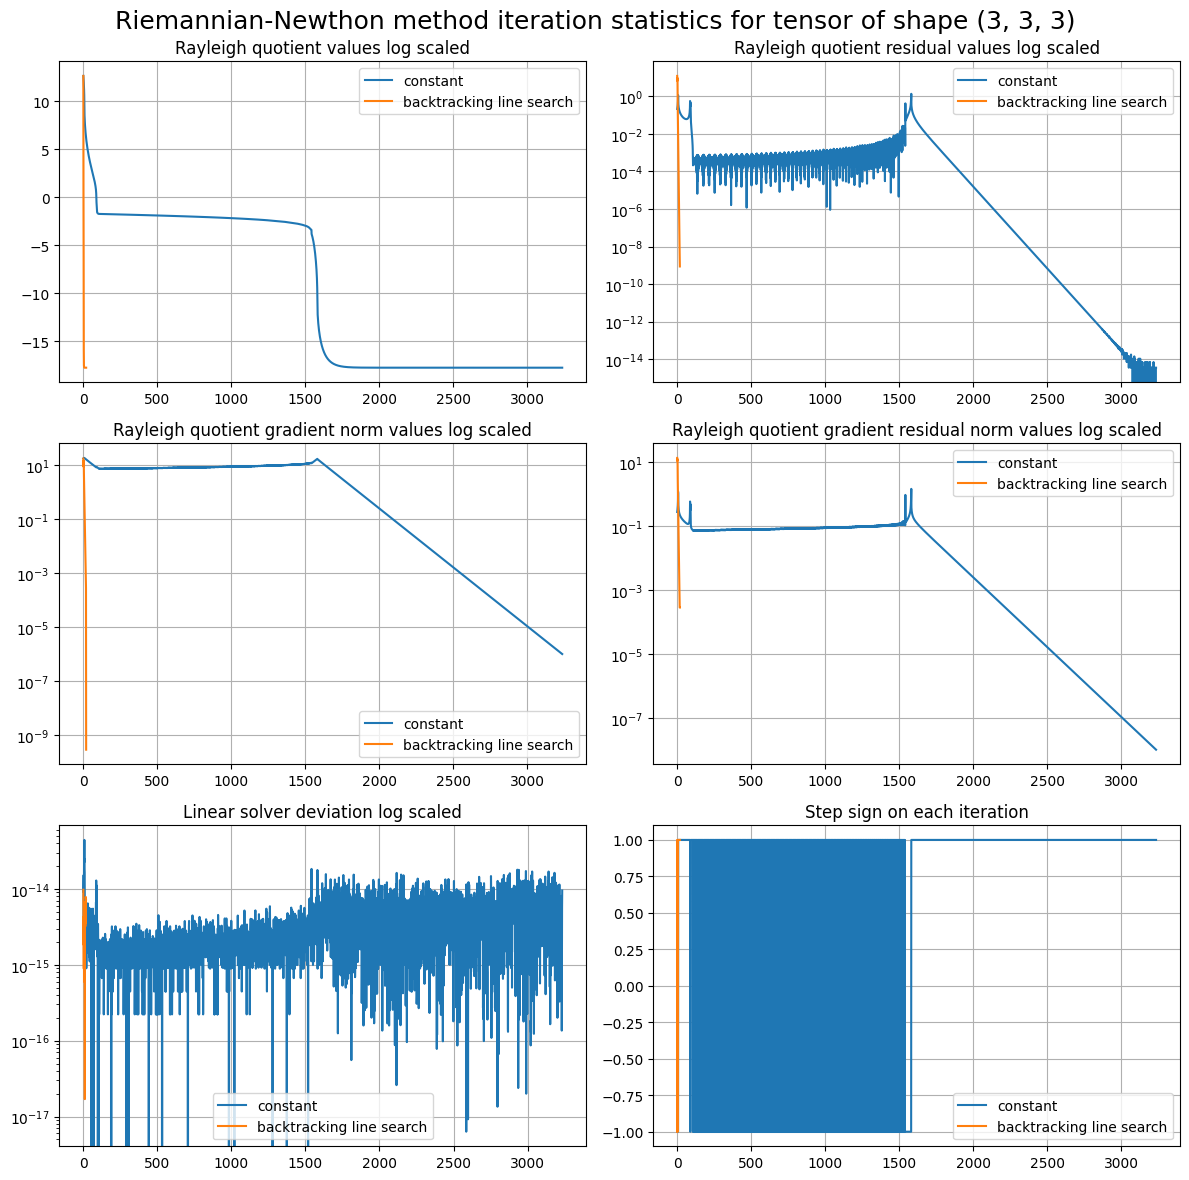

In [34]:
test_riemannian_newton_method_medium()

Riemannian-Newton method with constant step controller failed


AssertionError: 

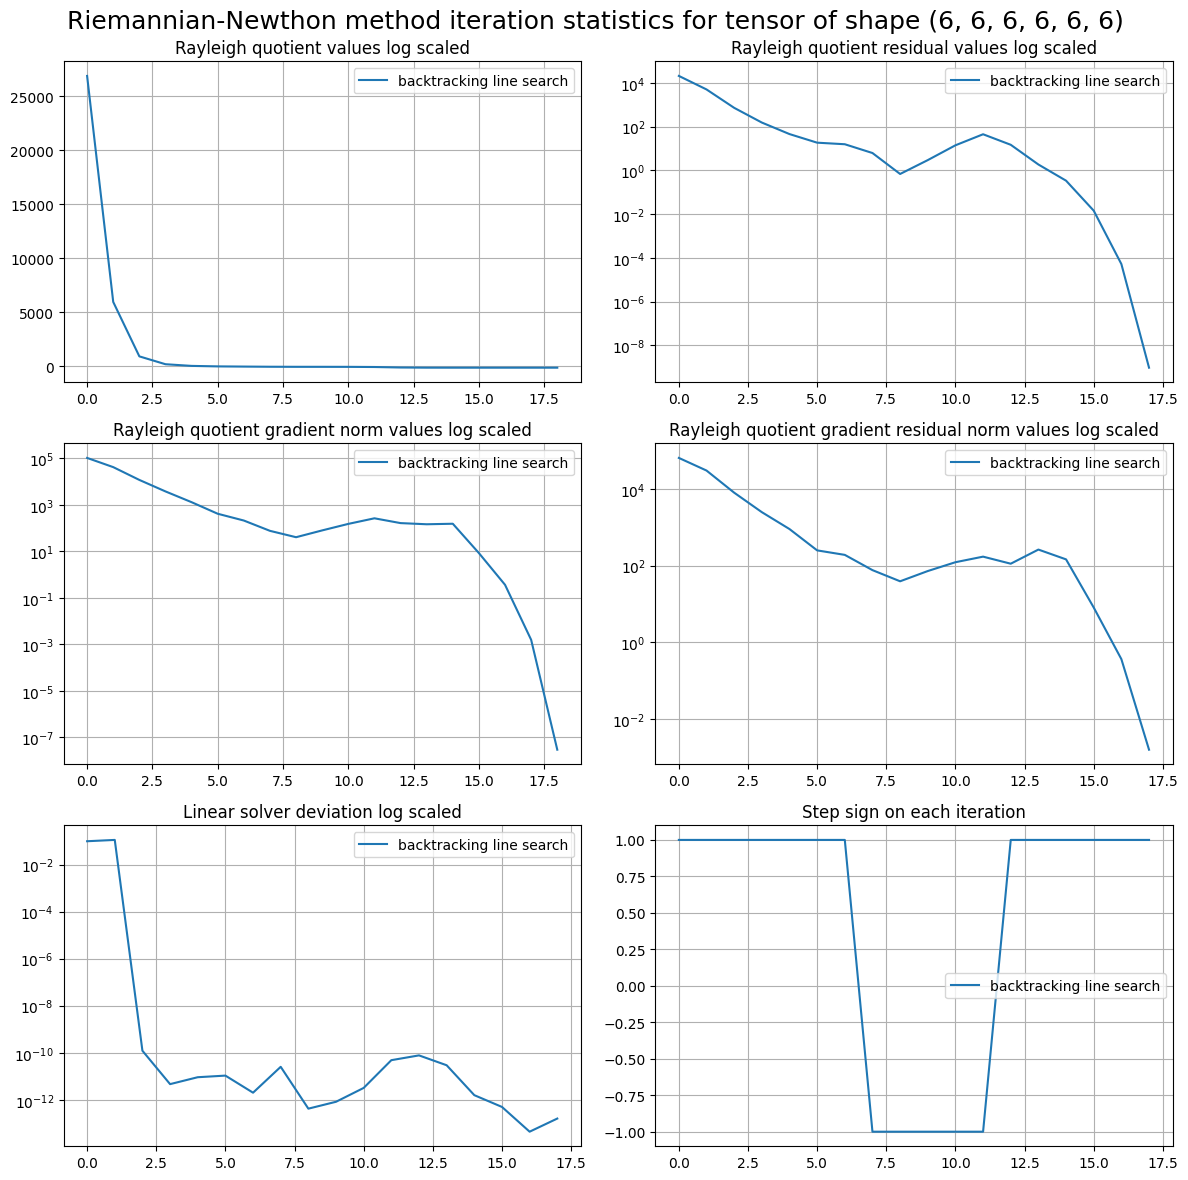

In [35]:
test_riemannian_newton_method_hard()